In [1]:
from functools import partial
from mixture_of_products_model_training import loss_fn, train_model, Datatuple, mask_input, pad_input
import time
import pickle
import argparse
import os
import h5py
import numpy as np
from jax import jit
import haiku as hk
import optax

hdf_src = '/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/birdflow_models/amewoo_2021_48km.hdf5'
file = h5py.File(hdf_src, 'r')

true_densities = np.asarray(file['distr']).T

weeks = true_densities.shape[0]
total_cells = true_densities.shape[1]

distance_vector = np.asarray(file['distances'])**0.5
distance_vector *= 1 / (100**0.5)
masks = np.asarray(file['geom']['dynamic_mask']).T.astype(bool)

dtuple = Datatuple(weeks, total_cells, distance_vector, masks)
distance_matrices, masked_densities = mask_input(true_densities, dtuple)
cells = [d.shape[0] for d in masked_densities]
nan_mask = np.asarray(file['geom']['mask']).flatten().astype(bool)
#distance_matrices, masked_densities = pad_input(distance_matrices, masked_densities, cells)
# get x / y dimensions of the grid
x_dim = int(np.asarray(file['geom']['ncol']))
y_dim = int(np.asarray(file['geom']['nrow']))

# Get the random seed and optimizer
key = hk.PRNGSequence(17)
optimizer = optax.adam(0.1)
max(cells)
print(len(masks))

53


In [3]:
import pickle
from mixture_of_products_model_training_gaussian import generate_coords_array

coords = generate_coords_array(cells, masks, nan_mask, x_dim, y_dim)
with open("/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/gaussian_mop_coords_lists/amewoo_2021_48km.hdf5", "wb") as f:
    pickle.dump(coords, f)
    

In [2]:
import matplotlib.pyplot as plt
from mixture_of_products_from_sampled_routes import get_boxed_weekly_marginal, get_unboxed_weekly_marginal
from jax.nn import softmax

def draw_box_marginal(cell, week, box_dim, masks, nan_mask, x_dim, y_dim, cells, conversion_dict):
    marginal = softmax(get_boxed_weekly_marginal(cell, week, cells, masks, nan_mask, x_dim, y_dim, box_dim, conversion_dict))
    medium_grid = np.empty(len(masks[week]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[nan_mask] = medium_grid
    big_grid = big_grid.reshape(y_dim, x_dim)
    plt.imshow(big_grid, cmap='winter')
    plt.show()

In [188]:
from mixture_of_products_from_sampled_routes import get_overall_to_weekly_mask_conversion_dict
week = 20
t0 = time.time()
conversion_dict = get_overall_to_weekly_mask_conversion_dict(nan_mask, masks[week])
t_conv = time.time() - t0
t1 = time.time()
marginal = get_unboxed_weekly_marginal(600, week, cells, masks, nan_mask, x_dim, y_dim, conversion_dict, 40)
t_total = time.time() - t1
print(t_total, t_conv)
print((t_total) * 52 * 1000 / 60)
#draw_box_marginal(50, week, 1, masks, nan_mask, x_dim, y_dim, cells, conversion_dict)

# ideas:
# - faster mvn implementation.

0.02597522735595703 0.005819082260131836
22.511863708496094


In [12]:
from mixture_of_products_from_sampled_routes import pdf_spherical_multivariate_normal
pdf_spherical_multivariate_normal(20, 0, 11)

returning: 1.837232583848601e-10


1.837232583848601e-10

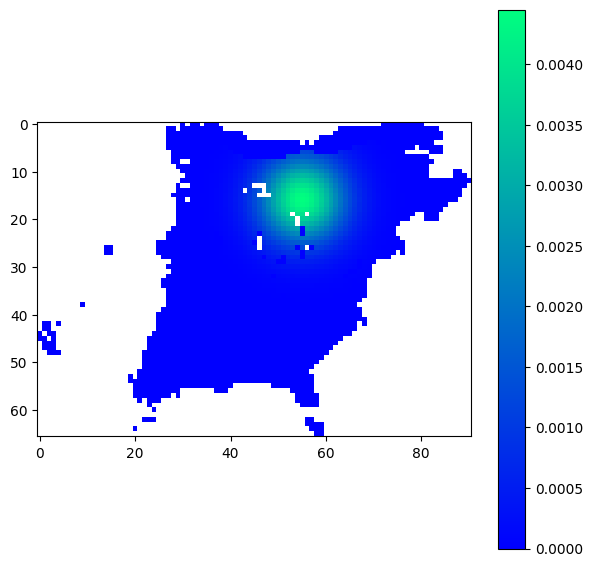

In [189]:
from mixture_of_products_model import compute_marginal
from jax.nn import softmax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
"""
Arguments
week: the week whose marginal we wish to fill into the grid to be plotted
marginal: the marginal from week "week"
masks: the dynamic masks. masks[week] is the one we care about
nan_mask: the mask used to eliminate oceans
x_dim: number of columns of final grid
y_dim: number of rows of the final grid

Returns:
A grid with all the densities of the weekly marginals filled in
"""
def make_grid(week, marginal, masks, nan_mask, x_dim, y_dim):
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[list(map(lambda b : b, nan_mask))] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

def plot_product_k_weekly_marginal(marginal, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    marginal_grid = make_grid(week, softmax(marginal), masks, nan_mask, x_dim, y_dim)
    
    # TODO: experiment with custom colormap
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

plot_product_k_weekly_marginal(marginal, week, masks, nan_mask, x_dim, y_dim)

In [ ]:
from mixture_of_products_from_sampled_routes import get_box
get_box(200, 0, masks, nan_mask, x_dim, y_dim, 5)


In [ ]:
def get_index_in_bigger_grid(cell, mask):
    true_count = -1
    new_cell = None
    for i, b in enumerate(mask):
        if b:
            true_count += 1
        if true_count == cell:
            new_cell = i
            break
    return new_cell

"""
cell: cell in grid of size len(mask)
mask: boolean array where true cells correspond to cells of a smaller grid
Returns: None if mask[cell] == False, index of cell in smaller grid (equals the number of True values in the mask before index cell)
"""
def get_index_in_smaller_grid(cell,mask):
    true_idx = -1
    if cell == None:
        return None
    if not mask[cell]:
        return None
    new_cell = None
    for i, b in enumerate(mask):
        if b:
            true_idx += 1
        if i == cell:
            new_cell = true_idx
            break
    return new_cell

def cell_to_xy(cell, x_dim, y_dim):
    x = cell % x_dim
    y = int(cell / x_dim)
    return x, y
    
def xy_to_cell(x, y, x_dim, y_dim):
    cell = y * x_dim + x
    return cell
    
"""
cell: grid cell index (center of the box)
week: week of the cell
masks: list of dynamic masks (we care about masks[week])
nan_mask: big mask used to eliminate oceans
x_dim, y_dim: dimensions of the overall grid
box_dim: number of cells from box center to edge (not counting the center)

Returns: box, a dictionary of idx, coords pairs, where idx is a cell index for given week, coords is a tuple of the coordinates for that cell 
"""

def get_box(cell, week, masks, nan_mask, x_dim, y_dim, box_dim):
    # grid cell index in weekly grid -> grid cell index in medium grid -> grid cell index in big grid
    medium_cell = get_index_in_bigger_grid(cell, masks[week])
    big_cell = get_index_in_bigger_grid(medium_cell, nan_mask)
    x_c, y_c = cell_to_xy(big_cell, x_dim, y_dim)
    box = {}
    for y in range(max(0,y_c-box_dim), min(y_dim, y_c+box_dim+1)):
        for x in range(max(0,x_c-box_dim), min(x_dim, x_c+box_dim+1)):
            # convert (x,y) in big grid -> cell in the big grid
            big_xy_cell = xy_to_cell(x, y, x_dim, y_dim)
            
            # convert big_xy_cell back to a cell in the small grid for week
            # store coordinates in box
            small_xy_cell = get_index_in_smaller_grid(get_index_in_smaller_grid(big_xy_cell, nan_mask), masks[week])
            if small_xy_cell != None:
                box[small_xy_cell] = (x-x_c,y-y_c)
    return box

#print(get_index_in_smaller_grid(get_index_in_smaller_grid(1000, nan_mask), masks[0]))
#list(map(lambda cell: len(get_box(cell, 0, masks, nan_mask, x_dim, y_dim, 10).keys()), range(cells[0])))
#list(map(lambda cell: len(get_box(cell,0,masks,nan_mask,x_dim,y_dim,2)), list(range(cells[0]))))
b = get_box(165,0,masks,nan_mask,x_dim,y_dim,1)
b, len(b)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from jax.nn import softmax
import jax.numpy as jnp
import math
"""
Arguments:
box: the box to apply the mvn to
week: the week of the marginal

Returns: a marginal with zeroes everywhere outside of the indices given by box
"""
def get_weekly_marginal(box_center, week, cells, masks, nan_mask, x_dim, y_dim, box_dim):
    box = get_box(box_center, week, masks, nan_mask, x_dim, y_dim, box_dim)
    marginal = np.empty(cells[week])
    marginal.fill(-50)
    for idx, coords in box.items():
        marginal[idx] = multivariate_normal.pdf(coords, mean=[0,0], cov=[[1, 0], [0, 1]])
    return jnp.array(marginal)

softmax(get_weekly_marginal(200, 1, cells, masks, nan_mask, x_dim, y_dim, 1))

In [ ]:
import matplotlib.pyplot as plt
def draw_box(box, week, masks, nan_mask, x_dim, y_dim):
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = masked_densities[week]
    for cell in box.keys():
        medium_cell_idx = get_index_in_bigger_grid(cell, masks[week])
        medium_grid[medium_cell_idx] = 0.010
    # convert everything to a big grid
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[nan_mask] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

def draw_box_marginal(box, week, masks, nan_mask, x_dim, y_dim, cells):
    marginal = softmax(get_weekly_marginal(box, week, cells))
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[nan_mask] = medium_grid
    big_grid = big_grid.reshape(y_dim, x_dim)
    return big_grid

In [ ]:
for i in range(200, 500):
    box = get_box(i, 0, masks, nan_mask, x_dim, y_dim, 1)
    grid = draw_box_marginal(box, 0, masks, nan_mask, x_dim, y_dim, cells)
    plt.imshow(grid, cmap='winter')
    plt.title(f"cell: {i}")
    plt.show()

In [ ]:
import pickle as pkl
import haiku as hk

from jax.nn import softmax
import jax.numpy as jnp
from jax.random import categorical

    
def sample_trajectory(rng_seq, flow_params, ipos=None, start=1, end=None):
    if end:
        end = end
    else:
        end = len(flow_params)
            
    if ipos:
        pos = ipos
    else:
        init_p = flow_params['Flow_Model/Initial_Params']['z0']
        pos = categorical(next(rng_seq), init_p)
    
    trajectory = [int(pos)]

    for week in range(start, end):
        trans_p = flow_params[f'Flow_Model/Week_{week}']['z'][pos, :]
        pos = categorical(next(rng_seq), trans_p)
        trajectory.append(int(pos))
    return trajectory

with open('../st_and_track_data_processing/amewoo_params_48_obs1.0_ent6e-06_dist0.025035_pow0.5.pkl', 'rb') as f:
    markov_params = pkl.load(f)
key = hk.PRNGSequence(42)

n_traj = 20
traj = [sample_trajectory(key, markov_params) for i in range(n_traj)]
traj = np.array(traj)

In [ ]:
len(traj), traj

In [ ]:
import jax.numpy as jnp
"""
Arguments:
routes: An n x T array of sampled routes (n sampled routes of T timesteps)
Returns:
mixture of products parameters, each components corresponds to one of the routes
"""
def mop_from_routes(routes, cells, masks, nan_mask, x_dim, y_dim, box_dim):
    n = routes.shape[0]
    mop_params = {'MixtureOfProductsModel': {'weights': jnp.ones(n)}}
    T = routes.shape[1]
    for t in range(T):
        week_t_components = jnp.empty((n, cells[t]))
        for k in range(n):
            week_t_components = week_t_components.at[k, :].set(get_weekly_marginal(routes[k][t], t, cells, masks, nan_mask, x_dim, y_dim, box_dim))
        mop_params['MixtureOfProductsModel'][f'week_{t}'] = week_t_components
    return mop_params

params = mop_from_routes(traj, cells, masks, nan_mask, x_dim, y_dim, 1)

In [ ]:
# plug params into the loss function
from mixture_of_products_model_training import loss_fn

loss_fn(params, cells, masked_densities, distance_matrices, 1, 0.025035, 6e-06, n_traj)

In [2]:
import pickle as pkl
fname = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/initial_components/amewoo_mop_from_routes_params_and_losses_48_obs1.0_ent0.0001_dist0.01_pow0.4_radius1_n1000_scale20.0_unboxedTrue.pkl"
with open(fname, 'rb') as f:
    params = pkl.load(f)

In [15]:
max(params['params']['MixtureOfProductsModel']['week_0'][0])

Array(-10., dtype=float32)

In [4]:
a = 2
if a in ['jacob', 'is', 2]:
    print(a)

2
